# Section 5.3 — Bayesian difference between means

This notebook contains the code examples from [Section 5.3 Bayesian difference between means]() from the **No Bullshit Guide to Statistics**.

See also [t-test.ipynb](./explorations/bambi/t-test.ipynb)


#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn"t work
from plot_helpers import RCPARAMS
RCPARAMS.update({"figure.figsize": (5, 3)})   # good for screen
# RCPARAMS.update({"figure.figsize": (5, 1.6)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# High-resolution please
%config InlineBackend.figure_format = "retina"

# Where to store figures
DESTDIR = "figures/bayesian/dmeans"

<Figure size 640x480 with 0 Axes>

In [3]:
# set random seed for repeatability
np.random.seed(42)
#######################################################

## Example movies genres

see https://www.andrewheiss.com/blog/2019/01/29/diff-means-half-dozen-ways/

see also https://bookdown.org/content/3686/metric-predicted-variable-on-one-or-two-groups.html#two-groups


In [4]:
movies = pd.read_csv("../datasets/movies.csv")
movies.head()

,title,year,rating,genre,genre_numeric
0,Blowing Wild,1953,5.6,Action,1
1,No Way Back,1995,5.2,Action,1
2,New Jack City,1991,6.1,Action,1
3,Noigwon,1983,4.2,Action,1
4,Tarzan and the Jungle Boy,1968,5.2,Action,1


In [5]:
movies.groupby("genre")["rating"].mean()

genre
Action    5.2845
Comedy    5.9670
Name: rating, dtype: float64

In [6]:
from scipy.stats import ttest_ind

actions = movies[movies["genre"]=="Action"]["rating"]
comedies = movies[movies["genre"]=="Comedy"]["rating"]

ttest_ind(actions, comedies, equal_var=True)

TtestResult(statistic=-4.47525173500199, pvalue=9.976981171112132e-06, df=398.0)

In [7]:
ttest_ind(actions, comedies, equal_var=False)

TtestResult(statistic=-4.47525173500199, pvalue=9.978285839671782e-06, df=397.7995256063933)

In [8]:
import bambi as bmb


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [44]:
# Model formula
levels = ["Comedy", "Action"]
formula = bmb.Formula("rating ~ 1 + C(genre, levels=levels)")

# Choose custom priors 
priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=5),
    "C(genre, levels=levels)": bmb.Prior("Normal", mu=0, sigma=1)
}

# Build model
model_eq = bmb.Model(formula, priors=priors, data=movies)

# Get model description
print(model_eq)

       Formula: rating ~ 1 + C(genre, levels=levels)
        Family: gaussian
          Link: mu = identity
  Observations: 400
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 5.0)
            C(genre, levels=levels) ~ Normal(mu: 0.0, sigma: 1.0)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 1.559)


AttributeError: 'NoneType' object has no attribute 'model'

In [50]:
# model_eq.build()
# model_eq.graph()

In [11]:
# Fit the model using 1000 on each chain
idata_eq = model_eq.fit(draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rating_sigma, Intercept, C(genre, levels=levels)]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


In [12]:
import arviz as az
az.summary(idata_eq, stat_focus="median")

,median,mad,eti_3%,eti_97%,mcse_median,ess_median,ess_tail,r_hat
Intercept,5.956,0.072,5.759,6.161,0.002,5919.285,2712.0,1.0
"C(genre, levels=levels)[Action]",-0.663,0.105,-0.948,-0.377,0.002,6063.053,3142.0,1.0
rating_sigma,1.525,0.037,1.431,1.633,0.001,5276.656,3283.0,1.0


### Regression, assuming unequal variances


In [13]:
levels = ["Comedy", "Action"]
formula_uneq = bmb.Formula("rating ~ 1 + C(genre,levels=levels)", "sigma ~ C(genre,levels=levels)")

priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=5),
    "C(genre, levels=levels)": bmb.Prior("Normal", mu=0, sigma=1),
    "sigma": {"C(genre, levels=levels)": bmb.Prior("Cauchy", alpha=0, beta=1)},
}

# Build model
model_uneq = bmb.Model(formula_uneq, priors=priors, data=movies)

# Get model description
print(model_uneq)
# model_uneq.build()
# model_uneq.graph()

       Formula: rating ~ 1 + C(genre,levels=levels)
                sigma ~ C(genre,levels=levels)
        Family: gaussian
          Link: mu = identity
                sigma = log
  Observations: 400
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 5.0)
            C(genre, levels=levels) ~ Normal(mu: 0.0, sigma: 1.0)
    target = sigma
        Common-level effects
            sigma_Intercept ~ Normal(mu: 0.0, sigma: 1.0)
            sigma_C(genre, levels=levels) ~ Cauchy(alpha: 0.0, beta: 1.0)


In [14]:
idata_uneq = model_uneq.fit(draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, C(genre, levels=levels), sigma_Intercept, sigma_C(genre, levels=levels)]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


In [15]:
az.summary(idata_uneq, stat_focus="median")

,median,mad,eti_3%,eti_97%,mcse_median,ess_median,ess_tail,r_hat
Intercept,5.958,0.075,5.753,6.151,0.002,5501.080,3402.0,1.0
"C(genre, levels=levels)[Action]",-0.667,0.101,-0.940,-0.384,0.003,6121.231,3284.0,1.0
sigma_Intercept,0.434,0.034,0.340,0.533,0.001,6062.634,3350.0,1.0
"sigma_C(genre, levels=levels)[Action]",-0.023,0.047,-0.154,0.113,0.001,5655.460,3044.0,1.0
sigma[0],1.507,0.050,1.377,1.660,0.001,6215.997,2575.0,1.0
...,...,...,...,...,...,...,...,...
sigma[395],1.544,0.053,1.406,1.703,0.001,6062.634,3350.0,1.0
sigma[396],1.544,0.053,1.406,1.703,0.001,6062.634,3350.0,1.0
sigma[397],1.544,0.053,1.406,1.703,0.001,6062.634,3350.0,1.0
sigma[398],1.544,0.053,1.406,1.703,0.001,6062.634,3350.0,1.0


In [16]:
np.exp(az.summary(idata_uneq, stat_focus="median").loc["sigma_C(genre, levels=levels)[Action]","median"])

0.9772624837732771

### BEST

In [17]:
levels = ["Comedy", "Action"]
formula_best = bmb.Formula("rating ~ 1 + C(genre,levels=levels)", "sigma ~ C(genre,levels=levels)")

priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=5),
    "C(genre, levels=levels)": bmb.Prior("Normal", mu=0, sigma=1),
    "sigma": {"C(genre, levels=levels)": bmb.Prior("Cauchy", alpha=0, beta=1)},
    "nu": bmb.Prior("Exponential", lam=1/29),
}

# Build model
model_best = bmb.Model(formula_best, priors=priors, family="t", data=movies)

# Get model description
print(model_best)
# model_best.build()
# model_best.graph()

       Formula: rating ~ 1 + C(genre,levels=levels)
                sigma ~ C(genre,levels=levels)
        Family: t
          Link: mu = identity
                sigma = log
  Observations: 400
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 5.0)
            C(genre, levels=levels) ~ Normal(mu: 0.0, sigma: 1.0)
        
        Auxiliary parameters
            nu ~ Exponential(lam: 0.0345)
    target = sigma
        Common-level effects
            sigma_Intercept ~ Normal(mu: 0.0, sigma: 1.0)
            sigma_C(genre, levels=levels) ~ Cauchy(alpha: 0.0, beta: 1.0)


In [18]:
idata_best = model_best.fit(draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rating_nu, Intercept, C(genre, levels=levels), sigma_Intercept, sigma_C(genre, levels=levels)]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


In [19]:
az.summary(idata_best, stat_focus="median")

,median,mad,eti_3%,eti_97%,mcse_median,ess_median,ess_tail,r_hat
Intercept,5.981,0.070,5.787,6.172,0.002,4154.820,2915.0,1.0
"C(genre, levels=levels)[Action]",-0.680,0.100,-0.960,-0.402,0.003,3883.913,2685.0,1.0
sigma_Intercept,0.387,0.040,0.268,0.495,0.002,3197.444,2080.0,1.0
"sigma_C(genre, levels=levels)[Action]",0.000,0.051,-0.142,0.144,0.002,3651.121,2894.0,1.0
rating_nu,32.079,13.955,9.874,105.416,0.455,3032.644,2062.0,1.0
...,...,...,...,...,...,...,...,...
sigma[395],1.472,0.059,1.307,1.640,0.002,3197.444,2080.0,1.0
sigma[396],1.472,0.059,1.307,1.640,0.002,3197.444,2080.0,1.0
sigma[397],1.472,0.059,1.307,1.640,0.002,3197.444,2080.0,1.0
sigma[398],1.472,0.059,1.307,1.640,0.002,3197.444,2080.0,1.0


### BEST with priors on variables instead of difference




In [42]:
levels = ["Comedy", "Action"]
formula_best2 = bmb.Formula("rating ~ 0 + C(genre,levels=levels)",
                            "sigma ~ 0 + C(genre,levels=levels)")

priors = {
    "C(genre, levels=levels)": bmb.Prior("TruncatedNormal", mu=6, sigma=2, lower=1, upper=10),
    "sigma": {"C(genre, levels=levels)": bmb.Prior("Cauchy", alpha=0, beta=1)},
    "nu": bmb.Prior("Exponential", lam=1/29),
}

# Build model
model_best2 = bmb.Model(formula_best2, priors=priors, family="t", data=movies)

# Get model description
print(model_best2)
# model_best2.build()
# model_best2.graph()

       Formula: rating ~ 0 + C(genre,levels=levels)
                sigma ~ 0 + C(genre,levels=levels)
        Family: t
          Link: mu = identity
                sigma = log
  Observations: 400
        Priors: 
    target = mu
        Common-level effects
            C(genre, levels=levels) ~ TruncatedNormal(mu: 6.0, sigma: 2.0, lower: 1.0, upper: 10.0)
        
        Auxiliary parameters
            nu ~ Exponential(lam: 0.0345)
    target = sigma
        Common-level effects
            sigma_C(genre, levels=levels) ~ Cauchy(alpha: 0.0, beta: 1.0)


In [21]:
idata_best2 = model_best2.fit(draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rating_nu, C(genre, levels=levels), sigma_C(genre, levels=levels)]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


In [22]:
az.summary(idata_best2, stat_focus="median")

,median,mad,eti_3%,eti_97%,mcse_median,ess_median,ess_tail,r_hat
"sigma_C(genre, levels=levels)[Comedy]",0.385,0.040,0.262,0.497,0.001,3433.909,2076.0,1.0
"sigma_C(genre, levels=levels)[Action]",0.384,0.037,0.280,0.489,0.001,3515.378,2336.0,1.0
rating_nu,30.345,13.420,9.972,105.726,0.420,2940.661,2236.0,1.0
"C(genre, levels=levels)[Comedy]",5.990,0.070,5.776,6.190,0.002,3812.929,2820.0,1.0
"C(genre, levels=levels)[Action]",5.294,0.074,5.090,5.493,0.002,3737.340,2513.0,1.0
...,...,...,...,...,...,...,...,...
sigma[395],1.469,0.059,1.300,1.644,0.002,3433.909,2076.0,1.0
sigma[396],1.469,0.059,1.300,1.644,0.002,3433.909,2076.0,1.0
sigma[397],1.469,0.059,1.300,1.644,0.002,3433.909,2076.0,1.0
sigma[398],1.469,0.059,1.300,1.644,0.002,3433.909,2076.0,1.0


In [23]:
np.exp(az.summary(idata_best2, stat_focus="median").loc["sigma_C(genre, levels=levels)[Action]","median"])

1.4681454416819895

## Example from original BEST paper

Data taken from `BESTexample-original.R` in `BEST.zip`
via https://web.archive.org/web/20170708173718/https://www.indiana.edu/~kruschke/BEST/


Steps following Matti Vuorre's [blog post](https://mvuorre.github.io/posts/2017-01-02-how-to-compare-two-groups-with-robust-bayesian-estimation-using-r-stan-and-brms/) see also [src](https://github.com/mvuorre/mvuorre.github.io/tree/main/posts/2017-01-02-how-to-compare-two-groups-with-robust-bayesian-estimation-using-r-stan-and-brms) notebook.

### Data

In [24]:
treated = np.array([101, 100, 102, 104, 102,  97, 105, 105,  98, 101, 100, 123, 105,
                    103, 100,  95, 102, 106, 109, 102,  82, 102, 100, 102, 102, 101,
                    102, 102, 103, 103,  97,  97, 103, 101,  97, 104,  96, 103, 124,
                    101, 101, 100, 101, 101, 104, 100, 101])
controls = np.array([ 99, 101, 100, 101, 102, 100,  97, 101, 104, 101, 102, 102, 100,
                     105,  88, 101, 100, 104, 100, 100, 100, 101, 102, 103,  97, 101,
                     101, 100, 101,  99, 101, 100, 100, 101, 100,  99, 101, 100, 102,
                      99, 100,  99])
d = pd.DataFrame({
    "group": ["treatment"]*len(treated) + ["control"]*len(controls), 
    "iq": np.concatenate([treated, controls])
})

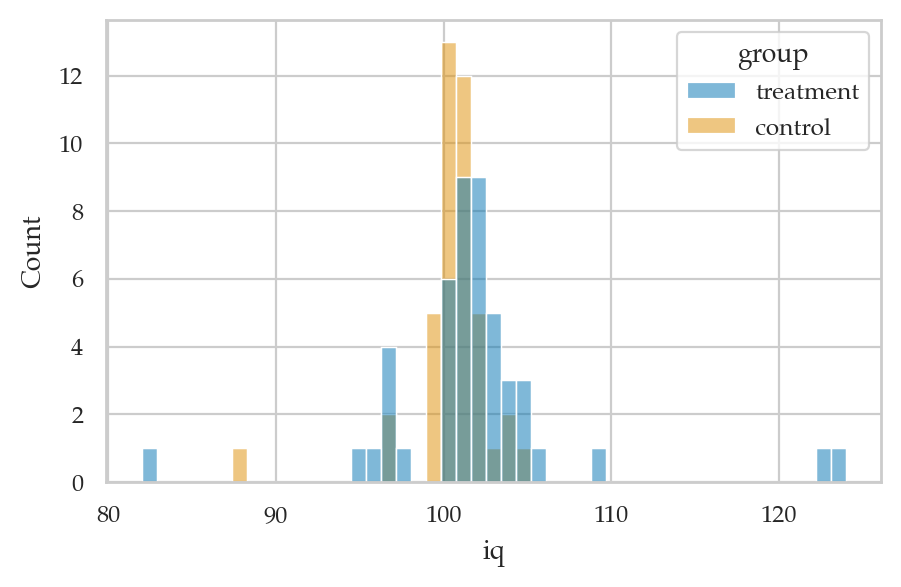

In [25]:
sns.histplot(data=d, x="iq", hue="group");

In [26]:
d.groupby("group").mean()

,iq
group,
control,100.357143
treatment,101.914894


### Equal variances t-test

In [27]:
from scipy.stats import ttest_ind

res_eqvar = ttest_ind(treated, controls, equal_var=True)
res_eqvar.statistic, res_eqvar.pvalue

(1.5586953301521096, 0.12269895509665575)

In [28]:
ci_eqvar = res_eqvar.confidence_interval(confidence_level=0.95)
[ci_eqvar.low, ci_eqvar.high]

[-0.42865302979133335, 3.5441545495481668]

### Unequal variances t-test

In [29]:
res_uneqvar = ttest_ind(treated, controls, equal_var=False)
res_uneqvar.statistic, res_uneqvar.pvalue

(1.622190457290228, 0.10975381983712831)

In [30]:
ci_uneqvar = res_uneqvar.confidence_interval(confidence_level=0.95)
[ci_uneqvar.low, ci_uneqvar.high]

[-0.3611847716497789, 3.476686291406612]

### Linear model

In [31]:
import statsmodels.formula.api as smf
res_ols = smf.ols("iq ~ 1 + C(group)", data=d).fit()
print(res_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                     iq   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     2.430
Date:                Mon, 19 Aug 2024   Prob (F-statistic):              0.123
Time:                        22:59:33   Log-Likelihood:                -263.13
No. Observations:                  89   AIC:                             530.3
Df Residuals:                      87   BIC:                             535.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               100.35

### Alternative linear model

Using generalized least squares to reproduce the unequal variance case.

In [32]:
n_t, var_t = len(treated), treated.var()
n_c, var_c = len(controls), controls.var()
sigma2s = [var_t]*n_t + [var_c]*n_c

res_gls = smf.gls("iq ~ 1 + C(group)", data=d, sigma=sigma2s).fit()
print(res_gls.summary())

                            GLS Regression Results                            
Dep. Variable:                     iq   R-squared:                       0.029
Model:                            GLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     2.629
Date:                Mon, 19 Aug 2024   Prob (F-statistic):              0.109
Time:                        22:59:33   Log-Likelihood:                -248.41
No. Observations:                  89   AIC:                             500.8
Df Residuals:                      87   BIC:                             505.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               100.35

## Bayesian equal variances model

In [33]:
import bambi as bmb

mod_eqvar = bmb.Model("iq ~ 1 + group", data=d)
print(mod_eqvar)

       Formula: iq ~ 1 + group
        Family: gaussian
          Link: mu = identity
  Observations: 89
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 101.1798, sigma: 17.17)
            group ~ Normal(mu: 0.0, sigma: 23.6275)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 4.718)


In [34]:
idata_eqvar = mod_eqvar.fit(draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [iq_sigma, Intercept, group]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 20 seconds.


In [35]:
import arviz as az

az.summary(idata_eqvar, kind="stats")

,mean,sd,hdi_3%,hdi_97%
Intercept,100.358,0.727,98.973,101.722
group[treatment],1.554,1.002,-0.358,3.365
iq_sigma,4.742,0.360,4.079,5.411


## Bayesian unequal variances model

In [36]:
formula = bmb.Formula("iq ~ 1 + group", "sigma ~ group")
mod_uneqvar = bmb.Model(formula, data=d)
print(mod_uneqvar)

       Formula: iq ~ 1 + group
                sigma ~ group
        Family: gaussian
          Link: mu = identity
                sigma = log
  Observations: 89
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 101.1798, sigma: 17.17)
            group ~ Normal(mu: 0.0, sigma: 23.6275)
    target = sigma
        Common-level effects
            sigma_Intercept ~ Normal(mu: 0.0, sigma: 1.0)
            sigma_group ~ Normal(mu: 0.0, sigma: 1.0)


In [37]:
idata_uneqvar = mod_uneqvar.fit(draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, group, sigma_Intercept, sigma_group]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 22 seconds.


In [38]:
az.summary(idata_uneqvar, kind="stats")

,mean,sd,hdi_3%,hdi_97%
Intercept,100.357,0.397,99.617,101.105
group[treatment],1.553,0.965,-0.177,3.434
sigma_Intercept,0.939,0.109,0.741,1.150
sigma_group[treatment],0.849,0.151,0.566,1.133
sigma[0],6.013,0.637,4.881,7.212
...,...,...,...,...
sigma[84],2.574,0.285,2.068,3.121
sigma[85],2.574,0.285,2.068,3.121
sigma[86],2.574,0.285,2.068,3.121
sigma[87],2.574,0.285,2.068,3.121


## Robust Bayesian Estimation

In [51]:
formula = bmb.Formula("iq ~ 1 + group", "sigma ~ group")
mod_robust = bmb.Model(formula, family="t", data=d)
print(mod_robust)

       Formula: iq ~ 1 + group
                sigma ~ group
        Family: t
          Link: mu = identity
                sigma = log
  Observations: 89
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 101.1798, sigma: 17.17)
            group ~ Normal(mu: 0.0, sigma: 23.6275)
        
        Auxiliary parameters
            nu ~ Gamma(alpha: 2.0, beta: 0.1)
    target = sigma
        Common-level effects
            sigma_Intercept ~ Normal(mu: 0.0, sigma: 1.0)
            sigma_group ~ Normal(mu: 0.0, sigma: 1.0)


In [41]:
idata_robust = mod_robust.fit(draws=1000)
az.summary(idata_robust, kind="stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [iq_nu, Intercept, group, sigma_Intercept, sigma_group]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


,mean,sd,hdi_3%,hdi_97%
Intercept,100.525,0.211,100.142,100.931
group[treatment],1.026,0.414,0.248,1.799
sigma_Intercept,0.009,0.196,-0.364,0.361
sigma_group[treatment],0.624,0.252,0.156,1.090
iq_nu,1.827,0.487,1.090,2.768
...,...,...,...,...
sigma[84],1.029,0.204,0.677,1.416
sigma[85],1.029,0.204,0.677,1.416
sigma[86],1.029,0.204,0.677,1.416
sigma[87],1.029,0.204,0.677,1.416
